In [1]:
import torch
from torch.utils.data import DataLoader

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.envs.scheduling.djssp.render import render

if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 32
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator_params = {
    "num_jobs":6 ,
    "num_machines": 6 ,
    "min_processing_time":1 ,
    "max_processing_time": 99 ,
    "mtbf" : 40 ,
    "mttr" : 5
  }


from rl4co.envs import JSSPEnv



env = DJSSPEnv(generator_params=generator_params,stepwise_reward=True)

In [3]:
import gc
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
from rl4co.utils.trainer import RL4COTrainer
import torch

# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="djsp",
    het_emb=False
)

model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=batch_size,
    train_data_size=train_data_size,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4}
)

C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [4]:
td = env.reset(batch_size=[1])


In [5]:
print(type(td["machine_breakdowns"]))

<class 'numpy.ndarray'>


In [6]:
td["proc_times"][0]

tensor([[  4.6339,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          46.8547,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          31.2250,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          68.5653,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  40.8541,   0.0000,  58.5555,   0.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   0.0000,  93.0789,   0.0000,   0.0000,   0.0000,
           0.0000,  19.9172,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,  69.0006,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   4.8663,   0.0000,   0.0000,   0.0000,   0.0000,  76.3113,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  70.6087,
           0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  12.8533,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,  78.8986,   0.0000,   0.0000,
           0

In [7]:
td["machine_breakdowns"][0]

{0: [{'TIME': 54.75002670288086, 'DURATION': 3.7722136974334717},
  {'TIME': 72.0903890132904, 'DURATION': 7.5723772048950195},
  {'TIME': 147.87190294265747, 'DURATION': 5.235101222991943},
  {'TIME': 302.3248209953308, 'DURATION': 0.75322425365448},
  {'TIME': 607.9281233549118, 'DURATION': 7.498149394989014},
  {'TIME': 1224.4561235904694, 'DURATION': 0.056421998888254166},
  {'TIME': 2440.335784200579, 'DURATION': 0.6652746200561523},
  {'TIME': 4892.171494014561, 'DURATION': 2.8291196823120117}],
 1: [{'TIME': 10.474533081054688, 'DURATION': 2.44407320022583},
  {'TIME': 14.267833352088928, 'DURATION': 2.6660666465759277},
  {'TIME': 33.21631586551666, 'DURATION': 2.4496192932128906},
  {'TIME': 74.57199501991272, 'DURATION': 2.1153275966644287},
  {'TIME': 144.2104377746582, 'DURATION': 0.26548948884010315},
  {'TIME': 287.56660041213036, 'DURATION': 6.945370674133301},
  {'TIME': 591.9182164669037, 'DURATION': 0.2785354256629944},
  {'TIME': 1204.1383238434792, 'DURATION': 2.065

In [8]:
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100,  select_best=True)


In [9]:
out

{'reward': tensor([-652.6301]),
 'log_likelihood': tensor([-8.3934]),
 'actions': tensor([[1, 2, 4, 5, 4, 2, 5, 6, 2, 2, 6, 2, 3, 2, 4, 5, 3, 5, 1, 6, 4, 1, 6, 5,
          3, 4, 1, 3, 4, 5, 6, 1, 1, 3, 6, 3]]),
 'td': TensorDict(
     fields={
         action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
         action_mask: Tensor(shape=torch.Size([1, 7]), device=cpu, dtype=torch.bool, is_shared=False),
         actual_proc_times: Tensor(shape=torch.Size([1, 6, 36]), device=cpu, dtype=torch.float32, is_shared=False),
         adjacency: Tensor(shape=torch.Size([1, 36, 36]), device=cpu, dtype=torch.float32, is_shared=False),
         busy_until: Tensor(shape=torch.Size([1, 6]), device=cpu, dtype=torch.float32, is_shared=False),
         done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
         end_op_per_job: Tensor(shape=torch.Size([1, 6]), device=cpu, dtype=torch.int64, is_shared=False),
         finish_times: 

TRII 0 22.362260818481445 0
TRII 3 68.71914672851562 18
TRII 4 82.44647979736328 24
TRII 5 109.6968002319336 30
TRII 1 22.87482452392578 6
TRII 2 58.82538986206055 12


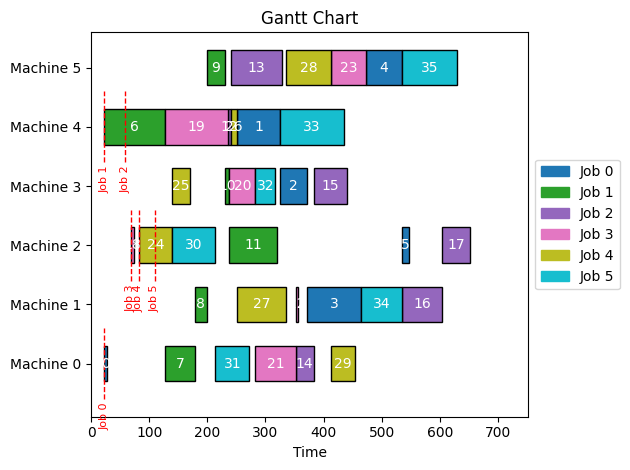

In [10]:
env.render(out["td"],0)

In [11]:
out["reward"]

tensor([-652.6301])

In [12]:
td = out["td"]
td["job_arrival_times"]

tensor([[ 22.3623,  22.8748,  58.8254,  68.7191,  82.4465, 109.6968]])

In [13]:
td["start_times"]

tensor([[ 22.3623, 251.5239, 324.8198, 371.5018, 473.6839, 534.7538,  22.8748,
         126.7410, 178.8308, 198.7480, 230.1624, 237.9310, 235.1949, 240.6232,
         351.8350, 383.0601, 535.1895, 604.4686,  68.7191, 126.7410, 237.9310,
         282.5165, 351.8350, 412.9197,  82.4465, 138.9478, 240.6232, 251.5239,
         334.7806, 412.9197, 138.9478, 213.6801, 282.5165, 324.8198, 464.5808,
         535.1895]])

In [14]:
td["machine_breakdowns"][0]

{0: [{'TIME': 54.75002670288086, 'DURATION': 3.7722136974334717},
  {'TIME': 72.0903890132904, 'DURATION': 7.5723772048950195},
  {'TIME': 147.87190294265747, 'DURATION': 5.235101222991943},
  {'TIME': 302.3248209953308, 'DURATION': 0.75322425365448},
  {'TIME': 607.9281233549118, 'DURATION': 7.498149394989014},
  {'TIME': 1224.4561235904694, 'DURATION': 0.056421998888254166},
  {'TIME': 2440.335784200579, 'DURATION': 0.6652746200561523},
  {'TIME': 4892.171494014561, 'DURATION': 2.8291196823120117}],
 1: [{'TIME': 10.474533081054688, 'DURATION': 2.44407320022583},
  {'TIME': 14.267833352088928, 'DURATION': 2.6660666465759277},
  {'TIME': 33.21631586551666, 'DURATION': 2.4496192932128906},
  {'TIME': 74.57199501991272, 'DURATION': 2.1153275966644287},
  {'TIME': 144.2104377746582, 'DURATION': 0.26548948884010315},
  {'TIME': 287.56660041213036, 'DURATION': 6.945370674133301},
  {'TIME': 591.9182164669037, 'DURATION': 0.2785354256629944},
  {'TIME': 1204.1383238434792, 'DURATION': 2.065

In [15]:
td["finish_times"]

tensor([[ 26.9962, 324.8198, 371.5018, 464.5808, 534.7538, 547.6072, 126.7410,
         178.8308, 198.7480, 230.1624, 237.9310, 319.6332, 240.6232, 328.3220,
         383.0601, 440.0158, 604.4686, 652.6301,  73.9839, 235.1949, 282.5165,
         351.8350, 356.7013, 473.6839, 138.9478, 170.0279, 251.5239, 334.7806,
         412.9197, 453.7739, 213.6801, 272.2356, 316.7744, 435.4322, 535.1895,
         629.8988]])

In [16]:
td["job_arrival_times"]

tensor([[ 22.3623,  22.8748,  58.8254,  68.7191,  82.4465, 109.6968]])

In [17]:
out["td"]["finish_times"]

tensor([[ 26.9962, 324.8198, 371.5018, 464.5808, 534.7538, 547.6072, 126.7410,
         178.8308, 198.7480, 230.1624, 237.9310, 319.6332, 240.6232, 328.3220,
         383.0601, 440.0158, 604.4686, 652.6301,  73.9839, 235.1949, 282.5165,
         351.8350, 356.7013, 473.6839, 138.9478, 170.0279, 251.5239, 334.7806,
         412.9197, 453.7739, 213.6801, 272.2356, 316.7744, 435.4322, 535.1895,
         629.8988]])

In [18]:
td["job_ops_adj"][0]

tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

In [19]:
td["ops_ma_adj"]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [20]:
td["start_op_per_job"]

tensor([[ 0,  6, 12, 18, 24, 30]])

In [21]:
td["ma_assignment"]

tensor([[[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [22]:
for op_no in td["start_op_per_job"].squeeze(0):
    machine_no = td["ma_assignment"][0,]
    print(op_no)

tensor(0)
tensor(6)
tensor(12)
tensor(18)
tensor(24)
tensor(30)


In [23]:
td["ma_assignment"][0][2,0]

tensor(0.)